# Загрузка зависимостей, данных

In [1]:
# работа данными таблицы
import pandas as pd
import numpy as np
# для визуализация
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
# для разделения данных на тестовую и обучаю подвыборки
from sklearn.model_selection import train_test_split
# для определения точности
from sklearn.metrics import balanced_accuracy_score
# модель классификации
from catboost import CatBoostClassifier, CatBoostRegressor
import plotly.io as pio
pio.renderers.default='notebook'

In [303]:
# загрузка "грязных" данных
df = pd.read_excel(io='./data/Train_labled.xlsx',engine='openpyxl')
df_test = pd.read_excel(io='./data/Test_unlabled.xlsx',engine='openpyxl')

In [304]:
# объекты предсказания храним отдельно
df_target = df['Текущий прогноз']
# признаки храним отдельно
df = df[df.columns[:-1]]

# Очистка и преобразования данных

In [305]:
# вывод общей инофрмации
def general_analys(df):
    # Первичный осмотр
    print(f'Размер данных:\nколичество строк({df.shape[0]})\nколичество признаков({df.shape[1]})')
    print('Какие типы данных используются:', *df.dtypes.unique())
    print('Количество дубликатов строк:', df.duplicated().sum())
    print('Количество дубликатов колонок:', df.T.duplicated().sum())
    print('Процентн Nan в датасете:', 
          round((100*df.isna().sum(axis=1).sum())/(df.shape[0]*df.shape[1]),2),'%')

general_analys(df)

Размер данных:
количество строк(259)
количество признаков(117)
Какие типы данных используются: int64 float64
Количество дубликатов строк: 0
Количество дубликатов колонок: 4
Процентн Nan в датасете: 8.67 %


###### У нас три класса для предсказания: 
                                0 - жив
                                1 - мертв
                                2 - жив с рецедивом

In [306]:
# визуализация процентного содержания классов предсказания в датасете
# подготовка данных
temp_pie_targ = df_target.value_counts()
values = temp_pie_targ.values.tolist()
# визуализация
fig = go.Figure(data=[go.Pie(labels=['жив','мертв','жив с рецидивом'], 
                             values=values, title='Распределение классов')])
fig.show()

## Наиболее коррелирующие с таргетом признаки

In [307]:
corr_with_targ = df.corrwith(df_target).sort_values(ascending=False).head(10)
px.histogram(y=corr_with_targ.values, x=corr_with_targ.index,
             labels={'x':'Название признака ', 'y':'    Корреляция с целью'})


### Проведя исследование значений колонок были выявлены зависимости и предприняты действия по улучшению данных:

In [308]:
#Проверка зависимостей

def checking_dependencies(df):
    ### Проверка значений '1. Scoring: Age'  
    # Правило подсчета Scoring age было получено из статьей про Charlson Comorbidity Index
    scoring_age = df['Возраст'].apply(lambda age: 0 if age<40 else age//10 -3)

    print('Правильно ли посчитан Scoring Age: ', (df['1. Scoring: Age'] == scoring_age).all())
    # изменение  '1. Scoring: Age'
    df['1. Scoring: Age'] = scoring_age

    ###Пересчитываем CCI с уже новыми значениями 1. Scoring: Age 
    df['Charlson Comorbidity Index, '] = df['Comorbidity Component'] + df['1. Scoring: Age'] 

    #добавление колонки с процентным объемом опухоли
    df.insert(48, 'объем_опухоли_в%',df['Объем опухоли, мл'] / df['Исходный v почки'])

    #проверка правильности расчета коэффицента PADUA
    padua = ['Размер', 'Exophitic', 'Sinus', 'Renal rim', 'Longitudinal', 'ЧЛС']
    print('Правильно ли посчитан PADUA: ',(df['PADUA'] == df[padua].sum(axis=1)).all())

    #проверка правильности расчета коэффицента RENAL
    renal = ['Размер', 'Экзофит >50% - <50% - эндофит', 'синус/члс >7, 4-7, <=4 мм', 'Polar lines']
    print('Правильно ли посчитан RENAL: ', (df['RENAL'] == df[renal].sum(axis=1)).all())
    
    return df

df = checking_dependencies(df)
df_test = checking_dependencies(df_test)

Правильно ли посчитан Scoring Age:  False
Правильно ли посчитан PADUA:  True
Правильно ли посчитан RENAL:  True
Правильно ли посчитан Scoring Age:  False
Правильно ли посчитан PADUA:  True
Правильно ли посчитан RENAL:  True


__При анализе было выявлено:__

- “рост2, м2 коррелирует с “рост” 
- Unnamed: 0  - Unnamed: 0.1  - просто индексы, смысла не несут
- рN,  M и эффект - просто нули и Nan содержат в себе
- Доступ первой резекции= Доступ первой резекции.1 - одинаковые значения - одну из них удаляем
- мтс != гистологический отступ мм  но - корреляция = 1 - одну из них удаляем (убираем мтс, потому что у него больше Nan’ов) 
- Исходный диагноз - . 1-98.8%,  2 - 1.02%. слишком большой перевес 1 класса. 
- основной вид гемостаза  - категории 1 или 2 (1 - 96.5%  ; 2 - 3.5%)
- Вскрытие собирательной системы  - 0 -  95.4% ; 1 - 4.6% 
- СКФ.1 - дублирует СКФ
- “Осложнения интраоперационные.1” и “Осложнения интраоперационные” не несут информации (сильный перевес одного из класссов) 
- pT при одностороннем поражении.1 - представляет собой “pT при одностороннем поражении” как-то расфасованное по группам ,  а также высоко коррелирует с ним (0.86)
- локализация - дублирует локализация.1 (хотя из-за одного выброса корреляция меняется с 0.99  до  0.08)
- ‘Размер.1’ - дублирует ‘Размер’
- ‘Доступ первой резекции.1’ - ‘дублирует Доступ первой резекции’
- ‘обнаружение дополнительных узлов’  -0 - 98.8% ; 1- 1.2% 
- ‘Число удаленных узлов’  -   1 - 98.8% ; 2 - 1.2%    
- ‘Гемотрансфузия’  -  0- 75.7%;   1 - 3.9%;  Nan - 20.4%  
- ‘Маннит’  - 0.0  -  0.733591   NaN  -  0.223938   1.0  -  0.042471   
- ‘Лазикс’  - 0.0  -  0.664093   NaN  -  0.223938  1.0  -  0.111969  
- ‘Расширенная операция/комбинированная’   - 0 - 0.984556    1- 0.015444  
- ‘гистологический край положительный’  - 0 -   0.992278 	1  -  0.007722 
- ‘Осложнения интраоперационные’  - да\нет   0  -  0.915058   1  -  0.084942
- ‘нехирургические ранние осложнения кроме ПН’  -  0  -  0.95 ; 1  -  0.02; 5   - 0.01; 3 - 0.003 
- ‘осложнения поздние’  -  0  -  0.99   ; 1  -  0.01
- ‘повторная операция’   -  0  -  0.97    1  -  0.03
- снижение темпа диуреза <0,5 мл/кг/ч на 6-12-<0,3 мл/кг/ч/24 часа (анурия)  -  0 -  0.92     ;   2 - 0.08
- Острый диализ  -   0 - 0.996  ; 1 - 0.004
- ‘Сохранение резецированной почки длительное’    -  0 -  0.965;   1 -  0.035/

In [309]:
# Удаление неинформативных признаков
def droping_columns(df):
    # при анализе смыслов колонок были выявлены колонки для удаления
    drop_columns = ['рост2, м2' ,  'Unnamed: 0',
                    'рN', 'M', 'эффект', 'Доступ первой резекции.1' ,
                    'основной вид гемостаза', 'Вскрытие собирательной системы',
                    'СКФ.1', 'локализация' , 'Размер.1', 'Исходный диагноз',
                    'обнаружение дополнительных узлов', 'Число удаленных узлов',
                    'Гемотрансфузия', 'Маннит', 'Лазикс', 
                    'Расширенная операция/комбинированная ', 'pT при одностороннем поражении.1',
                    'гистологический край положительный', 'Осложнения интраоперационные', 'Осложнения интраоперационные.1',
                    'нехирургические ранние осложнения кроме ПН',  'осложнения поздние',
                    'повторная операция ', 'снижение темпа диуреза <0,5 мл/кг/ч на 6-12-<0,3 мл/кг/ч/24 часа (анурия)',
                    'Острый диализ', 'Сохранение резецированной почки длительное', 'Исходная ХБП' ]

    # признаки учавствующие в зависмостях
    drop_columns +=  ['Объем опухоли, мл', 'Рост, см', 'Вес, кг', '1. Scoring: Age', 'Comorbidity Component', 'Размер', 'Exophitic', 'Sinus', 'Renal rim', 'Longitudinal', 'ЧЛС','Размер', 'Экзофит >50% - <50% - эндофит', 'синус/члс >7, 4-7, <=4 мм', 'Polar lines']
    
    df = df.drop(columns=drop_columns)
    #__________________________________
    
    
    
    # удаляет столбцы
    def drops(df, df_drop):
        drop_column = df_drop[df_drop].index.to_list()
        return df.drop(columns=drop_column)

    # удаление дупликатных столбцов
    df_drop = df.T.duplicated()
    df = drops(df, df_drop)
    #__________________________________

    
    # удаление столбцов с более 50% nan
    df_drop = (df.isnull().sum()/df.shape[0]) > 0.5
    df = drops(df, df_drop)
    #__________________________________


    # удлаение колонок с большим количеством (>70%) одного значения
    def clear_preponderance(column, x):
        temp = (column.value_counts(dropna=False, normalize=True) > x).sum()
        if temp:
            return True
        return False
    
    name_drop =[clear_preponderance(df[col], 0.7) for col in df.columns]
    drop_column = df.columns[name_drop].to_list()
    df = df.drop(columns=drop_column)
    #__________________________________

    
    return df
# чистка признакового пространства у тренировочного и тестового датасетов
df = droping_columns(df)
df = df.drop(columns=['Unnamed: 0.1'])
df_test = droping_columns(df_test)

# Анализ признаков после очистки

In [310]:
general_analys(df)

Размер данных:
количество строк(259)
количество признаков(43)
Какие типы данных используются: int64 float64
Количество дубликатов строк: 0
Количество дубликатов колонок: 0
Процентн Nan в датасете: 5.28 %


## Наиболее коррелирующие с таргетом признаки после очистки

In [311]:
corr_with_targ = df.corrwith(df_target).sort_values(ascending=False).head(10)
px.histogram(y=corr_with_targ.values, x=corr_with_targ.index,
             labels={'x':'Название признака ', 'y':'     Корреляция с целью'})


### Разбиение датасета на обущающую и тестовую выборки

In [312]:
X_train, X_test, y_train, y_test = train_test_split(df.values, df_target.values, 
                                                    train_size=0.5,
                                                    random_state=42)

### Распределение классов предсказания для валидационной и обущающей подвыборок

In [313]:

fig = go.Figure()
fig.add_trace(go.Histogram(histfunc="count", y=y_test, name="тестовая подвыборка", marker_color='#9A94BC'))
fig.add_trace(go.Histogram(histfunc="count", y=y_train, name="обучающая подвыборка",marker_color='#6FB8DE') )

fig.show()

#### разделение выборок по 50% было принято для более точной проверки обобщающей способности модели

# Обучение модели и её тестирование

In [314]:
# используем классифицирующую модель случайного леса с градиентным бустингом 
# 100 деревьев с максимальной глубиной 2
model = CatBoostClassifier(iterations=100, max_depth=2,verbose=False)
# обучаем
model.fit(X_train, y_train)
# делаем предсказания
y_pred = model.predict(X_test)
print('Точность предсказания:', balanced_accuracy_score(y_test, y_pred))

Точность предсказания: 1.0


##### параметры модели

In [315]:
model.get_params()

{'max_depth': 2, 'verbose': False, 'iterations': 100}

# Интерпретируемость и не переобучена ли модель

### Признаков с черезмерно завышенной важностью нет. Из этого следует, что модель не переобучена и утечки данных не произошло


In [316]:
# достаем значимость каждой колонки
weight = model.feature_importances_
weight = np.array((100*weight/weight.sum()).round(1))

# собираем названия признаков, учавствующих в предсказании
columns = df.columns[weight>0.].to_list()
# переводим значимость в проценты
weight = weight[weight>0.]

hist_weight = pd.Series(weight, index=columns).sort_values(ascending=False)

# визуализируем
px.histogram(histfunc='sum', y=hist_weight.values, x=hist_weight.index, 
             labels={'x':'Название признака ', 'y':'    Важность'})

### Визуализировав распределения некоторых важных для модели признаков видим, что по их положению можно разделить 3 класса. Из этого следует, что модель может давать точность 100% 

In [317]:
# визуализируем выбранные моделью признаки для разных классов
def plot_feature(features):#(feature1, feature2, feature3, feature4):
    #features = arg
    x1 = df[features[0]][df_target == 0]
    x2 = df[features[0]][df_target == 1]
    x3 = df[features[0]][df_target == 2]

    x12 = df[features[1]][df_target == 0]
    x22 = df[features[1]][df_target == 1]
    x32 = df[features[1]][df_target == 2]

    x13 = df[features[2]][df_target == 0]
    x23 = df[features[2]][df_target == 1]
    x33 = df[features[2]][df_target == 2]

    x14 = df[features[3]][df_target == 0]
    x24 = df[features[3]][df_target == 1]
    x34 = df[features[3]][df_target == 2]

    x15= df[features[4]][df_target == 0]
    x25= df[features[4]][df_target == 1]
    x35= df[features[4]][df_target == 2]

    
    fig = make_subplots(rows=4, cols=3)
    
    fig.add_trace(go.Scatter(x=x1, y=x12, mode='markers',  name='Жив', line_color="#0000ff"), 1,1)
    fig.add_trace(go.Scatter(x=x2, y=x22, mode='markers', name='Мертв', line_color="#AA00ff"), 1,1)
    fig.add_trace(go.Scatter(x=x3, y=x32, mode='markers',  name='Жив с рецедивом',line_color="#11ffAA"), 1,1)

    fig.add_trace(go.Scatter(x=x1, y=x13, mode='markers',  line_color="#0000ff"), 1,2)
    fig.add_trace(go.Scatter(x=x2, y=x23, mode='markers', line_color="#AA00ff"), 1,2)
    fig.add_trace(go.Scatter(x=x3, y=x33, mode='markers',  line_color="#11ffAA"), 1,2)

    fig.add_trace(go.Scatter(x=x12, y=x13, mode='markers',  line_color="#0000ff"), 1,3)
    fig.add_trace(go.Scatter(x=x22, y=x23, mode='markers', line_color="#AA00ff"), 1,3)
    fig.add_trace(go.Scatter(x=x32, y=x33, mode='markers',  line_color="#11ffAA"), 1,3)
    
    fig.add_trace(go.Scatter(x=x14, y=x1, mode='markers',  line_color="#0000ff"), 2,1)
    fig.add_trace(go.Scatter(x=x24, y=x2, mode='markers', line_color="#AA00ff"), 2,1)
    fig.add_trace(go.Scatter(x=x34, y=x3, mode='markers',  line_color="#11ffAA"), 2,1)

    fig.add_trace(go.Scatter(x=x14, y=x12, mode='markers',  line_color="#0000ff"), 2,2)
    fig.add_trace(go.Scatter(x=x24, y=x22, mode='markers', line_color="#AA00ff"), 2,2)
    fig.add_trace(go.Scatter(x=x34, y=x32, mode='markers',  line_color="#11ffAA"), 2,2)

    fig.add_trace(go.Scatter(x=x14, y=x13, mode='markers',  line_color="#0000ff"), 2,3)
    fig.add_trace(go.Scatter(x=x24, y=x23, mode='markers', line_color="#AA00ff"), 2,3)
    fig.add_trace(go.Scatter(x=x34, y=x33, mode='markers',  line_color="#11ffAA"), 2,3)

    fig.add_trace(go.Scatter(x=x15, y=x1, mode='markers',  line_color="#0000ff"), 3,1)
    fig.add_trace(go.Scatter(x=x25, y=x2, mode='markers', line_color="#AA00ff"), 3,1)
    fig.add_trace(go.Scatter(x=x35, y=x3, mode='markers',  line_color="#11ffAA"), 3,1)

    fig.add_trace(go.Scatter(x=x15, y=x12, mode='markers',  line_color="#0000ff"), 3,2)
    fig.add_trace(go.Scatter(x=x25, y=x22, mode='markers', line_color="#AA00ff"), 3,2)
    fig.add_trace(go.Scatter(x=x35, y=x32, mode='markers',  line_color="#11ffAA"), 3,2)

    fig.add_trace(go.Scatter(x=x15, y=x13, mode='markers',  line_color="#0000ff"), 3,3)
    fig.add_trace(go.Scatter(x=x25, y=x23, mode='markers', line_color="#AA00ff"), 3,3)
    fig.add_trace(go.Scatter(x=x35, y=x33, mode='markers',  line_color="#11ffAA"), 3,3)

    fig.add_trace(go.Scatter(x=x15, y=x14, mode='markers',  line_color="#0000ff"), 4,1)
    fig.add_trace(go.Scatter(x=x25, y=x24, mode='markers', line_color="#AA00ff"), 4,1)
    fig.add_trace(go.Scatter(x=x35, y=x34, mode='markers',  line_color="#11ffAA"), 4,1)
    
    
    fig.update_traces(hoverinfo="all")
    
    fig.show()
    
plot_feature(['хирургические ранние структура','PADUA', 'Кровопотеря', 'локализация.1','стадия ХПН'])   


### Как деревья в нашей модели принимают решения

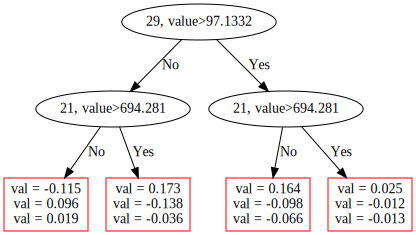

In [318]:
# индекс дерева
index_tree = 11
# как выглядит это дерево
model.plot_tree(index_tree)

# Обучение на тренировочном датасете и предсказания для теста

In [319]:
model = CatBoostClassifier(iterations=100, max_depth=2,verbose=False)
model.fit(df.values, df_target.values)
predict = model.predict(df_test.values)

# Сохранение предсказаний для теста

In [320]:
pd.DataFrame(predict).to_csv('Results.csv', index=False)

# Pipline для приватного датасета жюри (если будет)

In [321]:
##Подготовка данных
#data_frame = checking_dependencies(data_frame)
#data_frame = droping_columns(data_frame)
##предсказания
#predict = model.predict(data_frame.values)

# Предсказание признаков

### Выведена информация о признаках, которые удалось предсказать с точность более 70%

In [322]:

def model_feature(features, target, column):
    # предсказываем колонки только без Nan
    if len(target.isna().unique()) ==2:
        return
    
    # Предсказываем только классификацию
    if target.unique().size > 7:        
        return            
    else:
        task = 'классификация: balanced_accuracy_score'
        score = balanced_accuracy_score
        model = CatBoostClassifier(iterations=200, max_depth=3, verbose=False)
        if not target.isna().all():
            target = target.fillna(-1)

    X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, 
                                                    train_size=0.75,
                                                    random_state=42)
    
        
    # обучаем
    model.fit(X_train, y_train)
    # делаем предсказания
    y_pred = model.predict(X_test)
    scores = score(y_test, model.predict(X_test))
    if scores > 0.7:
        print(f'\nТочность предсказания "{column}"\nTest {task}:', scores)
        print(f'Train :', score(y_train, model.predict(X_train)))
    

# проходим по всем признакам
for column in df.columns:
    model_feature(df.drop(columns=column), df[column], column)




Точность предсказания "Пол"
Test классификация: balanced_accuracy_score: 0.8304597701149425
Train : 0.9366264803158006

Точность предсказания "Болезни, влияющие на ф-цию почек"
Test классификация: balanced_accuracy_score: 0.7620656370656371
Train : 0.9593280282935455

Точность предсказания "Charlson Comorbidity Index, "
Test классификация: balanced_accuracy_score: 0.7875396825396827
Train : 1.0


/home/pavel/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1854: UserWarning:

y_pred contains classes not in y_true




Точность предсказания "локализация.1"
Test классификация: balanced_accuracy_score: 0.7958959899749374
Train : 1.0

Точность предсказания "RENAL риск (4-6 vs 7-9 vs >=10)"
Test классификация: balanced_accuracy_score: 0.7632575757575757
Train : 1.0

Точность предсказания "сТ"
Test классификация: balanced_accuracy_score: 0.9444444444444444
Train : 1.0

Точность предсказания "Осложнения лечения"
Test классификация: balanced_accuracy_score: 0.7329222011385199
Train : 0.9114279170960724

Точность предсказания "ОПН"
Test классификация: balanced_accuracy_score: 0.9473684210526316
Train : 1.0
